In [17]:
import cv2
import time
import csv
import os
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display, clear_output, HTML
try:
    os.mkdir("data")
except:
    pass
cap = cv2.VideoCapture(2) # use 0 if you only have front facing camera

In [18]:
ret, frame = cap.read() #read one frame

In [22]:
Ntime = 200
top = 450
bottom = 750
stop = 126
start = 1600
Nslices = 4
height = bottom-top

def getslice(frame,i):
    loc = start + (stop-start)//(Nslices-1)*i
    return np.average(frame[top:bottom,loc],axis=-1)

ret, frame = cap.read() 

baselines = np.zeros((Nslices,height))
avg_N = 20
for n in range(avg_N):
    for i in range(Nslices):
        baselines[i] += getslice(frame,i)/avg_N

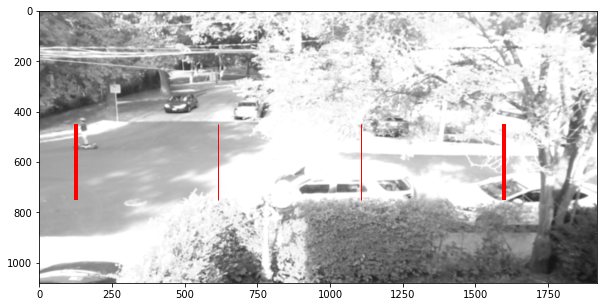

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(np.average(frame,axis=-1), interpolation = 'bicubic', cmap="gray",aspect = "auto")
for i in range(Nslices):
    loc = start + (stop-start)//(Nslices-1)*i
    lw = 1
    if i==0 or i==Nslices-1:
        lw = 4
    ax.vlines(loc,ymin=top,ymax=bottom,color="red",lw=lw)

In [ ]:
inprog = 0
threshhold = 6
avg_N = 0
event_N = 0
fails = 0
maxFails = 10
timesactive = np.zeros((Nslices))
avg = np.zeros((Nslices,height))
totallength = 17.65 # in m from start to stop
length_slice = totallength/(Nslices-1)
triggers = np.zeros((Nslices))


with open('data/log.csv','w', newline='') as logfile:
    writer = csv.writer(logfile)
    while True:
        ret, frame = cap.read()
        
        if fails <maxFails:
            if inprog<Nslices:
                cv = np.average(abs(baselines[inprog]-getslice(frame,inprog)))
                if cv > threshhold:
                    triggers[inprog] = cv
                    timesactive[inprog] = time.time()
                    if inprog ==0:
                        avg_N = 0
                        avg = np.zeros((Nslices,height))
                    inprog += 1
                    #clear_output(wait=True)
                    print("trigger:  %d %.2f %.2f" %(inprog,cv,threshhold))
                #clear_output(wait=True)
                #print("trigger:  %d %.2f %.2f" %(inprog,cv,threshhold))


            if inprog==Nslices:
                durations = timesactive[1:]-timesactive[:-1]
                speeds = 3.6*length_slice/durations
                speed_avg = np.average(speeds)
                speed_std = np.std(speeds)

                if speed_avg>100: #probably an error
                    print("too fast (%.1f km/h)"%speed_avg)
                    fails += 1
                    inprog = 0
                    continue
                if speed_std>25.: #probably an error
                    print("uncertain speed (%.1f km/h)"%speed_std)
                    fails += 1
                    inprog = 0
                    continue

                fails = 0
                date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                cv2.rectangle(frame,(0,800),(2000,2000), (0,0,0),thickness=-1)
                cv2.putText(frame,"Event: %d "%event_N, (70,880), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                cv2.putText(frame,"Time: " +date, (70,960), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                cv2.putText(frame,"Speed: %.1f (+/- %.1f) km/h"%(speed_avg,speed_std), (70,1040), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                small = cv2.resize(frame, (0,0), fx=0.25, fy=0.25) 
                _,ret = cv2.imencode('.jpg', small) 
                cv2.imwrite("data/image_%05d.jpg"%event_N, small) 
                clear_output()
                display(Image(data=ret))
                print(triggers)

                writer.writerow([event_N,date,speed_avg,speed_std])
                logfile.flush()                
                event_N += 1


                inprog = 0
                continue

            if inprog!=0:
                if time.time()-timesactive[0]>4:
                    print("miss (got %d of %d)"%(inprog,Nslices))
                    fails += 1
                    inprog = 0
                continue
        if inprog==0 or fails==maxFails:
            for i in range(Nslices):
                avg[i] += getslice(frame,i)
            avg_N += 1
            if avg_N == 20:
                if fails==maxFails:
                    print("force recalibrate")
                #change = np.max(np.average(np.abs(avg-baselines),axis=-1))
                #if change < threshhold:
                baselines = avg/avg_N
                avg_N = 0
                fails = 0
                inprog = 0
                avg = np.zeros((Nslices,height))


trigger:  1 6.38 6.00
miss (got 1 of 4)
trigger:  1 11.86 6.00
miss (got 1 of 4)
trigger:  1 7.46 6.00
trigger:  2 6.66 6.00
miss (got 2 of 4)
trigger:  1 6.55 6.00
miss (got 1 of 4)


In [ ]:
cap.release()